# CAPTCHA - ORC
    author: Oleg Naidovich
    
Работа будет оцениваться по следующим критериям:
1. Качество кода
2. Качество реализованного подхода
3. Качество описания принимаемых решений и анализа ошибок
4. Финальные метрики

# 1. Подготовка данных 
```
Нужно реализовать класс данных (наследник torch.utils.data.Dataset). Класс должен считывать входные изображения и выделять метки из имён файлов. Для чтения изображений предлагается использовать библиотеку Pillow. Дирректория содержит набор данных, который необходимо разделить на тренировочную и тестовую выборки в отношении четыре к одному.

```

In [1]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
class MyDataset(Dataset):
    def __init__(self, data_dir, image_names):
        self.data_dir = data_dir
        self.image_names = image_names
        self.mean = (0.485, 0.456, 0.406)
        self.std = (0.229, 0.224, 0.225)
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image_name = self.image_names[index]
        image_fp = os.path.join(self.data_dir, image_name)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_name.split(".")[0]
        return image, text
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=self.mean, std=self.std)])
        return transform_ops(image)

In [3]:
def get_train_test_loaders(data_path, image_names, batch_size):
    image_names_train, image_names_test = train_test_split(image_names, random_state=0)

    train_dataset = MyDataset(data_path, image_names_train) 
    test_dataset = MyDataset(data_path, image_names_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    return train_loader, test_loader

In [4]:
data_path = 'data/'
image_names = os.listdir(data_path)
image_names.remove('samples')
batch_size = 8

train_loader, test_loader = get_train_test_loaders(data_path, image_names, batch_size)

In [5]:
img_batch, text_batch = next(iter(train_loader))

In [6]:
img_batch.size()

torch.Size([8, 3, 50, 200])

# 2. Создание и обучение модели. 
    Код модели должен быть реализован через слои стандартной библиотеки torch (torchvision.models и аналоги использовать нельзя). Поскольку число символов в капче фиксировано, можно использовать обычный кросс- энтропийный критерий. Желающие могут использовать и CTC-loss. Цикл обучения можно реализовать самостоятельно или воспользоваться библиотеками PyTorch Lightning / Catalyst.

## Initialize model

In [7]:
import torch
from torchvision.models import resnet18
import torch.nn as nn


In [8]:
# NotImplementedError: The operator 'aten::_ctc_loss' is not currently implemented for the MPS device
device = torch.device('cpu')

In [9]:
RESNET = resnet18(weights=False)
# not to use pretrained params!!!

/Users/oleg-nai/opt/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [10]:
class CRNN(nn.Module):
    def __init__(self, n_chars):
        super(CRNN, self).__init__()

        self.cnn1 = nn.Sequential(*list(RESNET.children())[:-3])
        self.cnn2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True))
        
        self.lin1 = nn.Linear(1024, 256)
        self.lin2 = nn.Linear(256*2, n_chars)

        self.rnn1 = nn.GRU(input_size=256, 
                            hidden_size=256,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=256, 
                            hidden_size=256,
                            bidirectional=True, 
                            batch_first=True)
        
    def forward(self, batch):
        batch = self.cnn1(batch)
        batch = self.cnn2(batch) 
        batch = batch.permute(0, 3, 1, 2) 
         
        batch = batch.view(batch.size(0), batch.size(1), -1) 
        batch = self.lin1(batch)
        
        batch, hidden = self.rnn1(batch)
        batch = batch[:, :, :batch.size(2)//2] + batch[:, :, batch.size(2)//2:]
        
        batch, hidden = self.rnn2(batch)
        batch = self.lin2(batch)
        batch = batch.permute(1, 0, 2) 
        return batch

In [11]:
boot = "".join([image_name.split(".")[0] for image_name in image_names])
vocabulary = sorted(list(set(list(boot)))) + ["-"]

id_to_char = {k:v for k,v in enumerate(vocabulary, start=0)}
char_to_idx = {v:k for k,v in id_to_char.items()}

n_chars = len(char_to_idx)


In [12]:
crnn = CRNN(n_chars)
crnn = crnn.to(device)

In [13]:
text_batch_logits = crnn(img_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('6e2dg', 'm75bf', '7e2y7', 'x362g', 'nc4yg', '68x48', 'x347n', 'ec6pm')
torch.Size([13, 8, 20])


## Initialize loss

In [14]:
import torch.nn.functional as F

In [15]:
criterion = nn.CTCLoss()

In [16]:
def get_loss(batch, batch_logits):
    def ecode_batch(batch):
        boot = "".join(batch)
        txt_target = torch.IntTensor([char_to_idx[c] for c in boot])
        return txt_target, torch.IntTensor([len(text) for text in batch])

    batch_log = F.log_softmax(batch_logits, 2) 
    batch_log_len = torch.full(size=(batch_log.size(1),), 
                                     fill_value=batch_log.size(0), 
                                     dtype=torch.int32).to(device)

    batch_targets, batch_targets_len = ecode_batch(batch)
    loss = criterion(batch_log, batch_targets, batch_log_len, batch_targets_len)
    return loss

In [17]:
get_loss(text_batch, text_batch_logits)

tensor(5.5858, grad_fn=<MeanBackward0>)

## train model

In [18]:
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm

In [19]:
def plot_loss(iteration_losses):
    display.clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.title("Training loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.plot(iteration_losses)
    plt.show()

In [20]:
crnn = CRNN(n_chars)
crnn = crnn.to(device)

In [21]:
optimizer = optim.Adam(crnn.parameters())

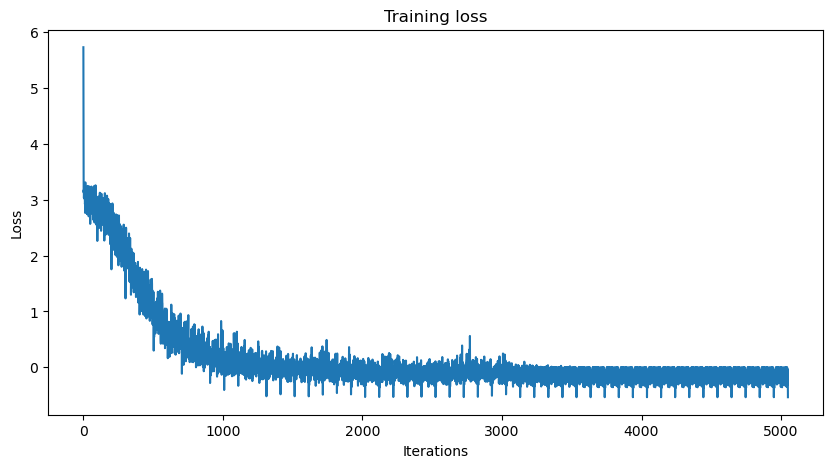

Epoch:50 Iteration_loss:-0.5346062779426575


In [22]:
n_epochs = 50
iteration_losses = []

for epoch in range(1, n_epochs+1):
    for img_batch, text_batch in train_loader:
        optimizer.zero_grad()
        text_batch_logits = crnn(img_batch.to(device))
        loss = get_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        iteration_losses.append(iteration_loss)
        
        loss.backward()
        optimizer.step()
        
        plot_loss(iteration_losses)
        print("Epoch:{} Iteration_loss:{}".format(epoch, iteration_loss))

# 3. Подсчет метрик. 
    После обучения нужно оценить точность предсказания на тестовой выборке. В качестве метрики предлагается использовать долю неверно распознанных символов, Character Error Rate (CER).

In [23]:
import pandas as pd

In [24]:
def decode_preds(batch_logits):
    batch_tokens = F.softmax(batch_logits, 2).argmax(2).numpy().T
    boot = []
    for tokens in batch_tokens:
        text = [id_to_char[idx] for idx in tokens]
        text = "".join(text)
        boot.append(text)
    return boot


def get_norm_preds(word):
    def rem(txt):
        if len(txt) > 1:
            tt = [txt[0]] + [lett for idx, lett in enumerate(txt[1:], start=1) if txt[idx] != txt[idx-1]]
        elif len(txt) == 1:
            tt = [txt[0]]
        else:
            return ""
        return "".join(tt)

    parts = word.split("-")
    parts = [rem(part) for part in parts]
    corr_word = "".join(parts)
    return corr_word

In [25]:
def get_results(is_train=True):
    if is_train: 
        loader = train_loader
    else:
        loader = test_loader
    res = pd.DataFrame(columns=['truth', 'preds'])
    for image_batch, batch in loader:
        batch_log = crnn(image_batch.to(device))
        batch_pred = decode_preds(batch_log.cpu())
        df = pd.DataFrame(columns=['truth', 'preds'])
        df['truth'] = batch
        df['preds'] = batch_pred
        res = pd.concat([res, df])
    res = res.reset_index(drop=True)
    res['preds'] = res['preds'].apply(get_norm_preds)
    return res

In [26]:
train_res = get_results(True)
test_res = get_results(False)

In [27]:
train_res.head()

,truth,preds
0,6e2dg,6e2d2g
1,m75bf,m275b2f
2,7e2y7,7e2y27
3,x362g,x362g
4,nc4yg,nc242y2g


# 4. Анализ ошибок модели. 

    В этой секции нужно найти изображения из тестового корпуса, на которых модель ошибается сильнее всего (по loss или по CER). Предлагается выписать в ноутбук возможные причины появления этих ошибок и пути устранения.

In [35]:
from sklearn.metrics import accuracy_score

In [40]:
train_accuracy = accuracy_score(train_res['truth'], train_res['preds'])
print(train_accuracy)
test_accuracy = accuracy_score(test_res['truth'], test_res['preds'])
print(test_accuracy)

0.04987531172069826
0.018656716417910446
